# Quantum Computing Signals

One of the great parts of the quantum computing development is the academic aspect behind it. Researchers from many different companies looking to develop the technology share their feats in the field by regularly publishing papers. While not all is revealed in those papers, consistently the leaders in the field are putting work out on advancements made in quantum computing while also advancing studies in other fields (such as quantum chemistry).

With more competitors entering the race for establishing true quantum advantage, I began to wonder if there was any correlation between a publicly traded quantum companies stock prices are correlated their publications.

## Hypothesis
*If a company publishes a paper on a date $t_0$, for some time horizon $t$ the stock price will increase a measurable amount.*

We say our *Null Hypothesis* ($H_0$) is that there is no measurable correlation between the stock price and the time horizon after a paper has been published.


# IonQ

We will start with looking at a single, quantum computing based company to see if our signal exists. While a company like IBM which has a large dedication is appealing, since quantum computing is only a part of its total porfolio, choosing it may make initial data exploration difficult. IonQ, on the other hand, is an established name in the field, while soley focusing on quantum computing, making it a good starting point for our investigation. 

Like above with our analysis we will start with small exploration and build up as we begin to test more rigorously.

## Getting Data

We will start by collecting appropiate data for exploration. First, we will use Yahoo! Finance `yfinance` to get price data for IONQ from 2020 to 2025. We will use `Pandas` to store data in a `DataFrame` and to export data to a csv.

In [1]:
import yfinance as yf
import pandas as pd

In [47]:
ticker = "IONQ"
start_date = "2020-01-01"

stock_data = yf.download(
    ticker,
    start=start_date,
)

stock_data.to_pickle("../data/ionq_price_data.pkl")

/var/folders/z6/_3pyslnx09v4vxgrswzkct1h0000gn/T/ipykernel_73542/805427523.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(
[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,IONQ,IONQ,IONQ,IONQ,IONQ
Date,,,,,
2021-01-04,10.80,11.25,10.50,11.125,150500
2021-01-05,11.11,11.83,10.75,10.850,165300
2021-01-06,11.05,11.50,11.00,11.500,175600
2021-01-07,11.11,11.50,11.05,11.500,94200
2021-01-08,11.01,12.35,11.00,11.650,137500


In [4]:
stock_data['return'] = stock_data['Close'].pct_change()

We will use the package `arxiv` (https://pypi.org/project/arxiv/) to query the arxiv website for papers with mentions of quantum and IonQ, and store the title, authors, publish-date, and url in a `DataFrame` to also be saved to a csv. We will filter results that occur before the first ticker data we have for IONQ:

In [50]:
import arxiv

search = arxiv.Search(
    query="Quantum AND IonQ",
    max_results=120,
    sort_by=arxiv.SortCriterion.SubmittedDate
)

papers = []
for result in search.results():
    if pd.Timestamp(result.published.date()) >= stock_data.index[0]:
        papers.append({
            "title": result.title,
            "authors": [a.name for a in result.authors],
            "published": pd.Timestamp(result.published.date()),
            "url": result.entry_id
        })

arxiv_df = pd.DataFrame(papers)
arxiv_df = arxiv_df.sort_values(by='published', ascending=True)
arxiv_df = arxiv_df.set_index('published')
arxiv_df.to_pickle("../data/arxiv_pubs.pkl")

/var/folders/z6/_3pyslnx09v4vxgrswzkct1h0000gn/T/ipykernel_73542/2807544362.py:10: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


In [6]:
arxiv_df.head()

,title,authors,published,url
0,Quantum algorithms for solving a drift-diffusi...,"[Ellen Devereux, Animesh Datta]",2025-09-25,http://arxiv.org/abs/2509.21509v1
1,Scaling Hybrid Quantum-HPC Applications with t...,"[Srikar Chundury, Amir Shehata, Seongmin Kim, ...",2025-09-17,http://arxiv.org/abs/2509.14470v1
2,Quantum Causality: Resolving Simpson's Paradox...,[Pilsung Kang],2025-08-31,http://arxiv.org/abs/2509.00744v1
3,Vectorized Attention with Learnable Encoding f...,"[Ziqing Guo, Ziwen Pan, Alex Khan, Jan Balewski]",2025-08-25,http://arxiv.org/abs/2508.18464v2
4,Guided sampling ansätzes for variational quant...,"[Daniel Gunlycke, John P. T. Stenger, Andrii M...",2025-08-19,http://arxiv.org/abs/2508.13926v1


## Investigation

Now that we have our data, we can start to explore any possible relation between the returns of the asset and the publication of a paper. First, Let's explore some of our data, and plot the returns of IONQ over our collected window:

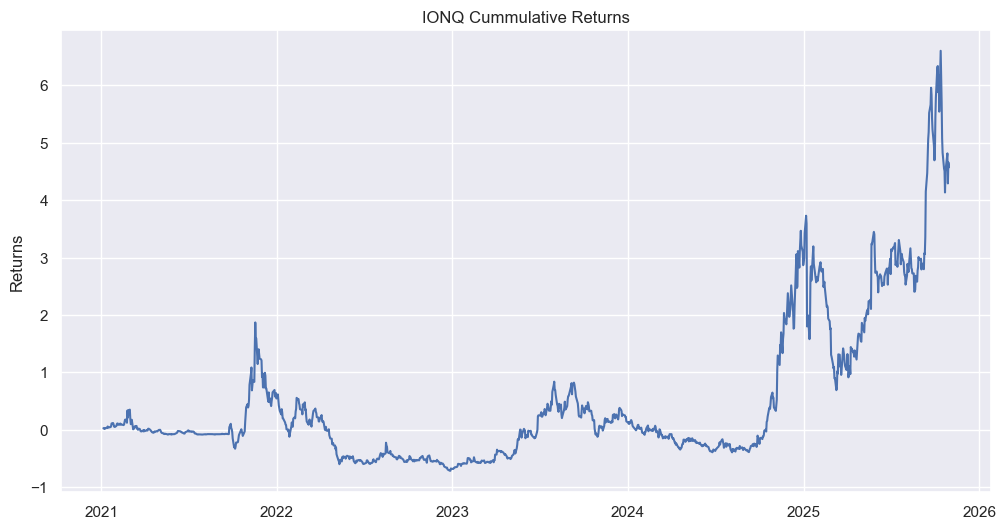

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

ax, fig = plt.subplots(figsize=(12,6))
_ = plt.plot(((1+stock_data['return']).cumprod()-1))
_ = plt.ylabel("Returns")
_ = plt.title("IONQ Cummulative Returns")

We can see that here are some large movements in the ticker price in late 2021 and a large jump at the end of 2025 followed by another large jump in the beginning of 2025 until present day. Let's look at the overall market to see if these are isolated events before looking deeper into these:

/var/folders/z6/_3pyslnx09v4vxgrswzkct1h0000gn/T/ipykernel_73542/2513834947.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market = yf.download(
[*********************100%***********************]  1 of 1 completed


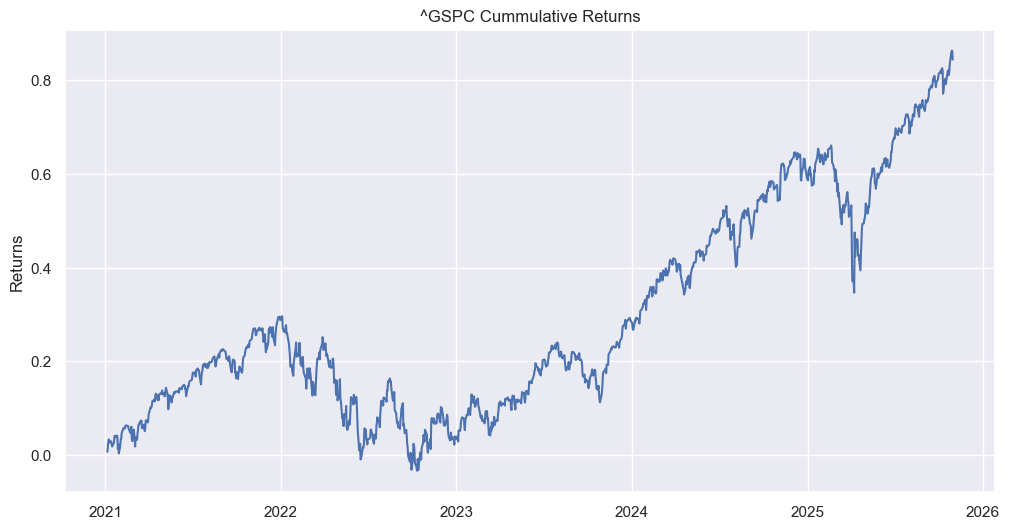

In [10]:
market = yf.download(
    "^GSPC",
    start=stock_data.index[0],
)

market_returns = market['Close'].pct_change()

ax, fig = plt.subplots(figsize=(12,6))
_ = plt.plot(((1+market_returns).cumprod()-1))
_ = plt.ylabel("Returns")
_ = plt.title("^GSPC Cummulative Returns")

We can see that IONQ may have suffered from overall market conditions worsening in early 2025 during the beginning of the tarrif implementation. the jumps, however, seem to be largley unique to the asset itself. Finally we can look at the summary statistics for the IONQ returns over the data window:

In [11]:
stock_data['return'].describe()

count    1212.000000
mean        0.003256
std         0.061357
min        -0.389998
25%        -0.029795
50%         0.000000
75%         0.029646
max         0.365236
Name: return, dtype: float64

Let's now look at our paper data:

In [12]:
arxiv_df[['title','published']]

,title,published
0,Quantum algorithms for solving a drift-diffusi...,2025-09-25
1,Scaling Hybrid Quantum-HPC Applications with t...,2025-09-17
2,Quantum Causality: Resolving Simpson's Paradox...,2025-08-31
3,Vectorized Attention with Learnable Encoding f...,2025-08-25
4,Guided sampling ansätzes for variational quant...,2025-08-19
...,...,...
100,"Sampling on NISQ Devices: ""Who's the Fairest O...",2021-07-14
101,Quantum Amplitude Amplification Operators,2021-05-20
102,Experimental QND measurements of complementari...,2021-05-13
103,Playing quantum nonlocal games with six noisy ...,2021-05-11


From our query there are 105 papers in *ArXiv* that are associated with IonQ and reference "Quantum". There is one particular point worth noting about the *arXiv* before we proceed into the analysis. For one, papers put out on *arXiv* are often pre-prints, or "white papers", with no indication of whether the authors intend to submit the paper to a formal journal or not. As a result, the size of the audience that the paper will reach largley depends on if it is only on the *arXiv* or if it is published to a another journal (such as *Nature*). 

We will dive into this further and how we could test variations of our hypothesis in the analysis section.

## Analysis

We will explore several different approaches to identify potential correlation between IONQ returns and publications in the *arXiv*.

### Cummulative Abnormal Returns (CAR)

The idea behind the Cummulative Abnormal Return (CAR) metric is relatively straight forward: compare the actual returns of the asset to the expected returns of the asset, and identify areas where the returns significantly deviated from the expected returns as our abonormal returns. We then calculate CAR by summing the abnormal returns over a period of interest (from a publication date to a selected time horizon). 

To get the abnormal returns, we can use a simple market model. The expected returns are defined as 

$$
E(R_i) = \alpha_i + \beta_iR_i^M,
$$

where $\alpha$ is the assets alpha parameter, $beta$ is the stocks beta, and $R^M$ is the returns of the overall market. From here, we would subtract the expected returns $E(R_i)$ from the actual returns $R_i$ to get our CAR. So how do we get $\beta$ and $alpha$? We can regress the returns of IonQ against the returns of ^GSPC! This changes our equation:

$$
R_i \sim \alpha_i + \beta_iR_i^M + \epsilon_i.
$$

We can see we've denoted regression with the $\sim$ symbol. We also have added a variable to the equation. The new variable, $\epsilon$, represents the residual from the regression at each timepoint $i$. Since this is a linear regression, we will have some error associated with our final fitted parameters and the actual values of $R_i$, which we can access in `results.resid`. Since $\epsilon$ represents our deviation from our "expected" return relationship, we can just use regression residual as the abnormal returns!

To carry out the regression, we will use the `statsmodels` library, and use `OLS`.

In [17]:
import statsmodels.api as sm

x = stock_data['return'].fillna(0)
x = sm.add_constant(x)
y = market_returns.loc[stock_data.index].fillna(0)

reg = sm.OLS(y,x)

results = reg.fit()

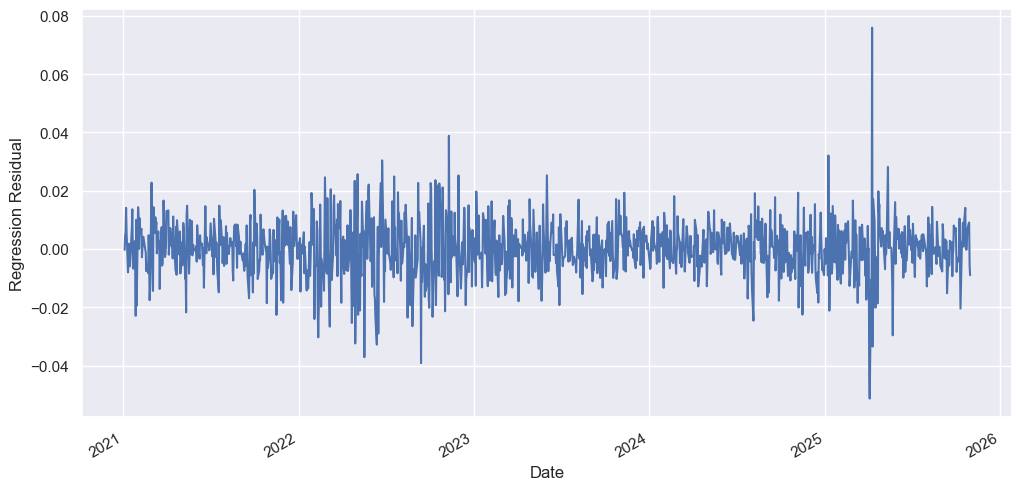

In [44]:
ax, fig = plt.subplots(figsize=(12,6))
_ = results.resid.plot()
_ = plt.ylabel("Regression Residual")

Having the abnormal returns, we can now go about looking at CAR. For each paper, we will calculate a CAR over a specific window length starting from the day the publication occurs. Starting with a sample CAR with 5-day window, and get an idea about the metric and what we should test for significance: 

In [26]:
def compute_car(stock_returns, event_index, window=5):
    return stock_returns[event_index:event_index+window+1].sum()

cars = []
for event_date in arxiv_df['published']:
    if event_date in stock_data.index:
        idx = stock_data.index.get_loc(event_date)
        car = compute_car(results.resid, idx)
        cars.append(car)
        
cars = pd.Series(cars)

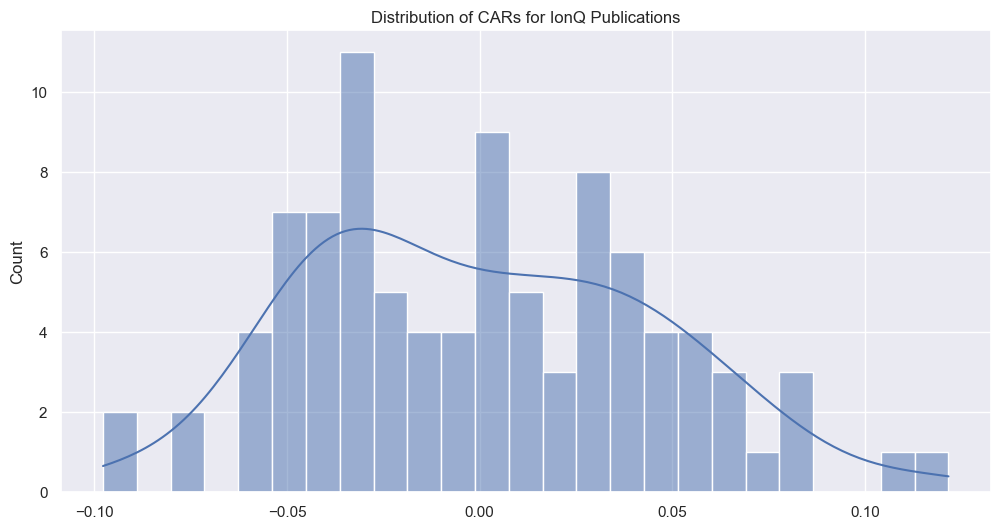

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
ax, fig = plt.subplots(figsize=(12,6))
sns.histplot(cars, bins=25, kde=True)
plt.title("Distribution of CARs for IonQ Publications")
plt.show()

Above we have the distribution for our CAR for the 105 publications we found from IonQ for a 5 day window after the paper was published. We can see, aside from the non-uniform peak, the curve roughly can be approximated to a bell-curve. We can also look at the mean and the standard deviation to get a better understanding of this distribution:

In [21]:
print(f"CAR mean for 5-day window : {cars.mean()}")
print(f"CAR standard deviation for 5-day window : {cars.std()}")

CAR mean for 5-day window : 0.0003487207632414485
CAR standard deviation for 5-day window : 0.01847655632569897


We will want to examine the distribution of our CAR for multiple windows, and see if there are time horizons with significant deviations from mean of zero.

In [36]:
import scipy.stats as stats

windows = [i for i in range(0,36)]

t_stat_df = pd.DataFrame(index=windows)

for window in windows:
    cars = []
    for event_date in arxiv_df['published']:
        if event_date in stock_data.index:
            idx = stock_data.index.get_loc(event_date)
            car = compute_car(results.resid, idx, window=window)
            cars.append(car)
    
    cars = pd.Series(cars)
    cars = cars.dropna()
    
    t_stat_df.loc[window,'Mean'] = cars.mean()
    t_stat_df.loc[window,'Std'] = cars.std()
    
    tstat, pval = stats.ttest_1samp(cars, 0.0)
    
    t_stat_df.loc[window,'t'] = tstat
    t_stat_df.loc[window,'p-value'] = pval
    


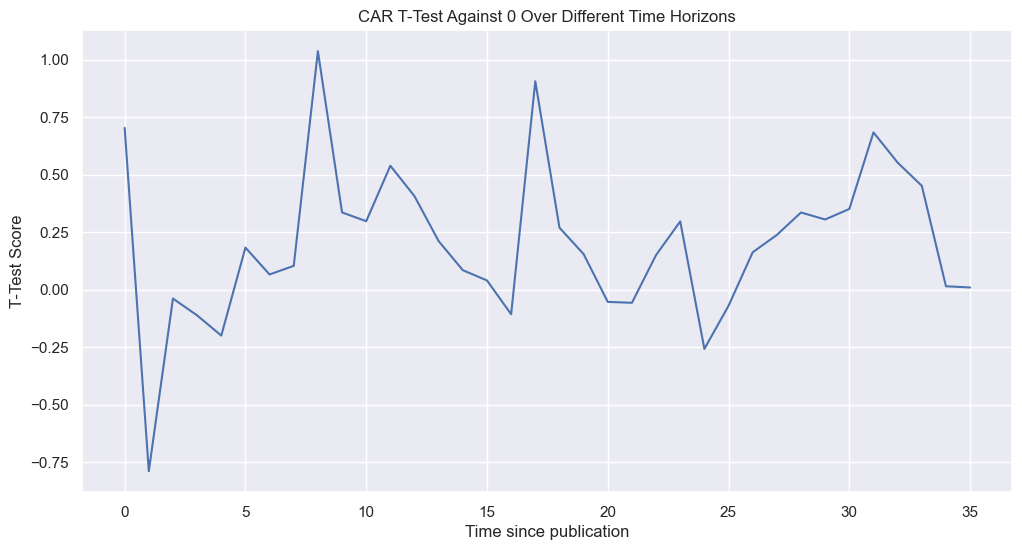

In [46]:
ax, fig = plt.subplots(figsize=(12,6))
_ = plt.plot(t_stat_df.index, t_stat_df['t'])
_ = plt.xlabel("Time since publication")
_ = plt.ylabel("T-Test Score")
_ = plt.title("CAR T-Test Against 0 Over Different Time Horizons")

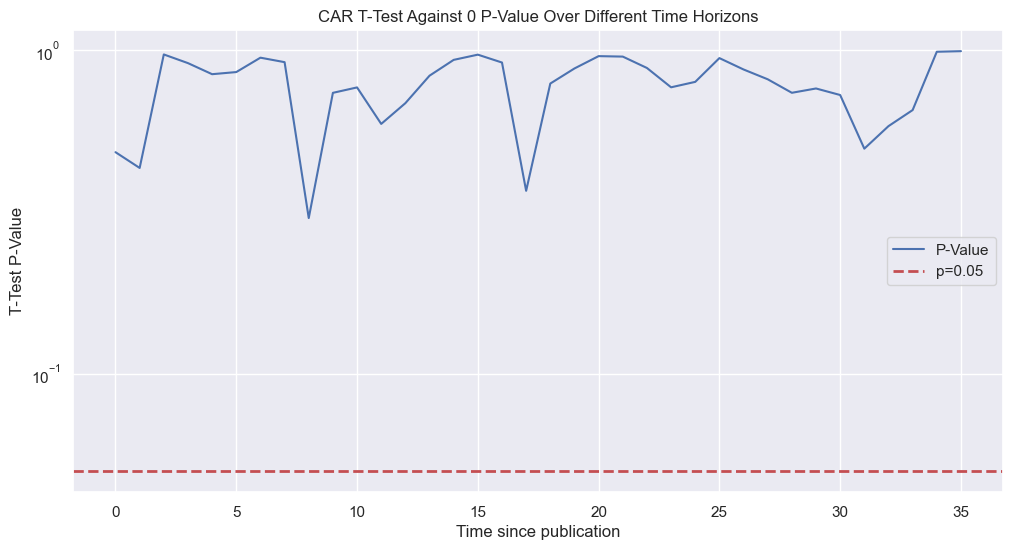

In [51]:
ax, fig = plt.subplots(figsize=(12,6))
_ = plt.semilogy(t_stat_df.index, t_stat_df['p-value'], label='P-Value')
_ = plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='p=0.05')
_ = plt.xlabel("Time since publication")
_ = plt.ylabel("T-Test P-Value")
_ = plt.title("CAR T-Test Against 0 P-Value Over Different Time Horizons")
_ = plt.legend()

# Discussion

From above we can see that there is no dicernable pattern in the cummulative average returns surrounding the date of a publication by reserach teams at IonQ. We do not have enough information to reject our $H_0$. There are several reasons this result could be: 1) first and foremost, our $H_0$ could be true; there could be no pattern in the returns and paper publication. 2) above we regressed IonQ against market returns over a 4-year period, assuming that the relationship between the market and IonQ ($\beta$) was constant. We could examine a rolling regression to see how the results change with a new residual from this more realistic approach. 3) As we mentioned above, arXiv papers are not guaranteed to be published in big name journals. Could it be that if we limited our approach to papers that were put out in more formal journals (such as nature), would the results change? If we looked at press-releases for the papers by IonQ would that change anything?

These are all things to consider. In the next notebook, we will look more into using a rolling regression to try and better estimate the abnormal returns from our regression.